Installing dependencies on Colab

In [ ]:
!git clone https://github.com/mdefrance/signature-detection.git
!pip install poetry
%cd signature-detection
!poetry config virtualenvs.create false 
!poetry install
%cd src

In [ ]:
from google.colab import output

output.enable_custom_widget_manager()

Logging into HF hub

In [1]:
import os

from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Access the Hugging Face Hub API token
huggingfacehub_api_token = os.getenv('HUGGINGFACEHUB_API_TOKEN')

# Log in to the Hugging Face Hub
login(token=huggingfacehub_api_token)

Loading tech4humans signature dataset

In [2]:
from datasets import load_dataset

# Load the tech4humans signature dataset
dataset = load_dataset("samuellimabraz/signature-detection")

# Print the dataset to verify it has been loaded correctly
print(dataset["train"][0])

{'image_id': 1825, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x2D7AA66C110>, 'width': 640, 'height': 640, 'objects': {'id': [2134, 2135, 2136, 2137], 'area': [5081, 1064, 4626, 1503], 'bbox': [[198.0, 55.0, 43.060001373291016, 118.0], [263.0, 195.0, 24.750999450683594, 43.0], [518.0, 37.0, 46.72800064086914, 99.0], [587.0, 157.0, 28.908000946044922, 52.0]], 'category': [0, 0, 0, 0]}}


Converting it to CocoDataset

In [3]:
from utils.dataset import convert_to_coco

output_dir = "datasets"

convert_to_coco(dataset["train"], output_dir, "train", save_images=True)
convert_to_coco(dataset["validation"], output_dir, "val", save_images=True)
convert_to_coco(dataset["test"], output_dir, "test", save_images=True)


Processing test: 100%|██████████| 419/419 [00:01<00:00, 244.02it/s]


Loading pre-trained model

In [2]:
from utils.config import TARGET
from transformers import YolosImageProcessor, YolosForObjectDetection

CKPT_PATH = "hustvl/yolos-tiny"
IMG_SIZE = 640
ID2LABEL = {0: TARGET}
LABEL2ID = {TARGET: 0}

image_processor = YolosImageProcessor.from_pretrained(CKPT_PATH, do_resize=True, size={"width": IMG_SIZE, "height": IMG_SIZE})
model = YolosForObjectDetection.from_pretrained(CKPT_PATH, num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID, ignore_mismatched_sizes=True, device_map="cpu")

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converting data into COCO format

In [3]:
from utils.dataset import SignatureDataset

train_dataset = SignatureDataset(img_folder='datasets/images/train', ann_file="datasets/train.json", image_processor=image_processor)
val_dataset = SignatureDataset(img_folder='datasets/images/val', ann_file="datasets/val.json", image_processor=image_processor)
test_dataset = SignatureDataset(img_folder='datasets/images/test', ann_file="datasets/test.json", image_processor=image_processor)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    """Custom collate function to handle batches of data."""
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    
    return {
        "pixel_values": encoding["pixel_values"],
        "labels": labels,
    }

BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE)
batch = next(iter(train_dataloader))
batch["pixel_values"].shape

torch.Size([8, 3, 640, 640])

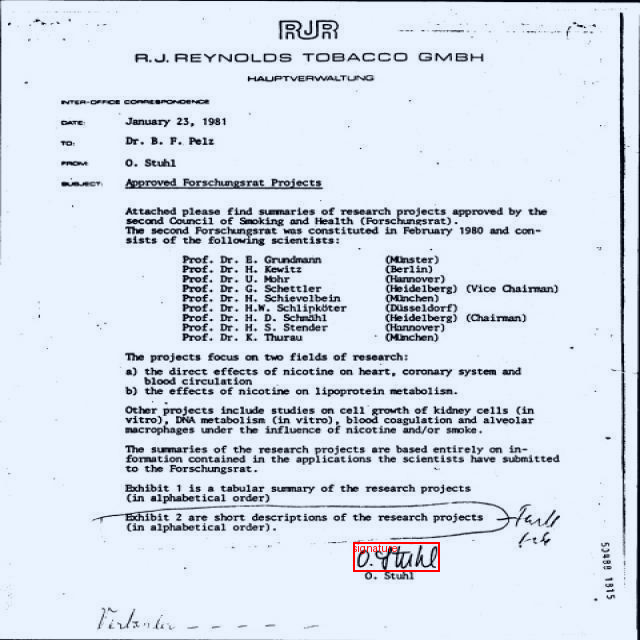

In [5]:
from utils.visualizer import visualize_item

visualize_item(test_dataset[0])

Fine-tuning the model

In [ ]:
from utils.model import YolosForSignatureDetection

pl_model = YolosForSignatureDetection(lr=2.5e-5, weight_decay=1e-4, model=model)  # balloon lr=2e-5
# pl_model = YolosForSignatureDetection(lr=1e-4, weight_decay=1e-4, model=model, train_dl=train_dataloader, val_dl=val_dataloader)  # signature lr=1e-4 

outputs = pl_model(pixel_values=batch["pixel_values"].to(model.device))
outputs.logits.shape

torch.Size([4, 100, 2])

In [9]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 18208), started 0:30:47 ago. (Use '!kill 18208' to kill it.)

In [ ]:
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=5, verbose=True)

# Create a ModelCheckpoint callback
validation_callback = ModelCheckpoint(monitor="validation_loss", mode="min", save_top_k=1, filename="best-val-checkpoint", verbose=True)
training_callback = ModelCheckpoint(monitor="training_loss", mode="min", save_top_k=1, filename="best-train-checkpoint", verbose=True)

callbacks = [early_stopping, validation_callback, training_callback]

In [ ]:
from pytorch_lightning import Trainer

# creating trainer 
# accumulate_grad_batches = 4 allows the model to accumulate gradients over 4 batches before performing a backward pass, effectively simulating a larger batch size.
# gradient_clip_val is set to 0.1 to prevent exploding gradients, which can occur during training, especially with larger models or datasets.
trainer = Trainer(max_epochs=100, gradient_clip_val=0.1, accumulate_grad_batches=4, callbacks=callbacks)

# Fit the model using the trainer
trainer.fit(pl_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M  | eval
---------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.885    Total estimated model params size (MB)
0         Modules in train mode
224       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\defra\AppData\Local\pypoetry\Cache\virtualenvs\signature-detection-Nok2ZUKi-py3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Loading checkpoint

In [ ]:
import torch

checkpoint = torch.load("lightning_logs/version_3/checkpoints/best-val-checkpoint.ckpt", map_location="cuda", weights_only=False)
pl_model = YolosForSignatureDetection(lr=1e-4, weight_decay=1e-4, model=model)
pl_model.load_state_dict(checkpoint["state_dict"])

Evaluating model

In [24]:
import json

from utils.evaluate import evaluate_model

# model evaluation
evaluation = evaluate_model(test_dataset.coco, test_dataloader, yolos.model, yolos.image_processor)

# Save the evaluation results to a JSON file
with open("evaluation-yolos-tiny.json", "w", encoding="utf-8") as f:
    json.dump(evaluation, f, indent=4)

Running evaluation...


  0%|          | 0/53 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.39s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.856
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Saving fine-tuned model to the Hub

In [ ]:
hf_model_name = CKPT_PATH.split("/")[-1] + "-signature-detection"
print("model saved at:", hf_model_name)

# saving model locally
# pl_model.model.save_pretrained(hf_model_name)
# processor.save_pretrained(hf_model_name)

# saving model to the Hub
# pl_model.model.push_to_hub(hf_model_name)
# processor.push_to_hub(hf_model_name)


model saved at: yolos-small-signature-detection


# Inference example

In [26]:
from transformers import pipeline

yolos = pipeline(
    task="object-detection",
    model="mdefrance/yolos-tiny-signature-detection",
    device_map="auto",
    use_fast=True,
)


Device set to use cuda:0


In [27]:
from utils.visualizer import convert_tensor_to_pil_image

# applying inference on images of the test set
predictions = yolos([convert_tensor_to_pil_image(item[0]) for item in test_dataset], batch_size=4)

Visualizing prediction and input

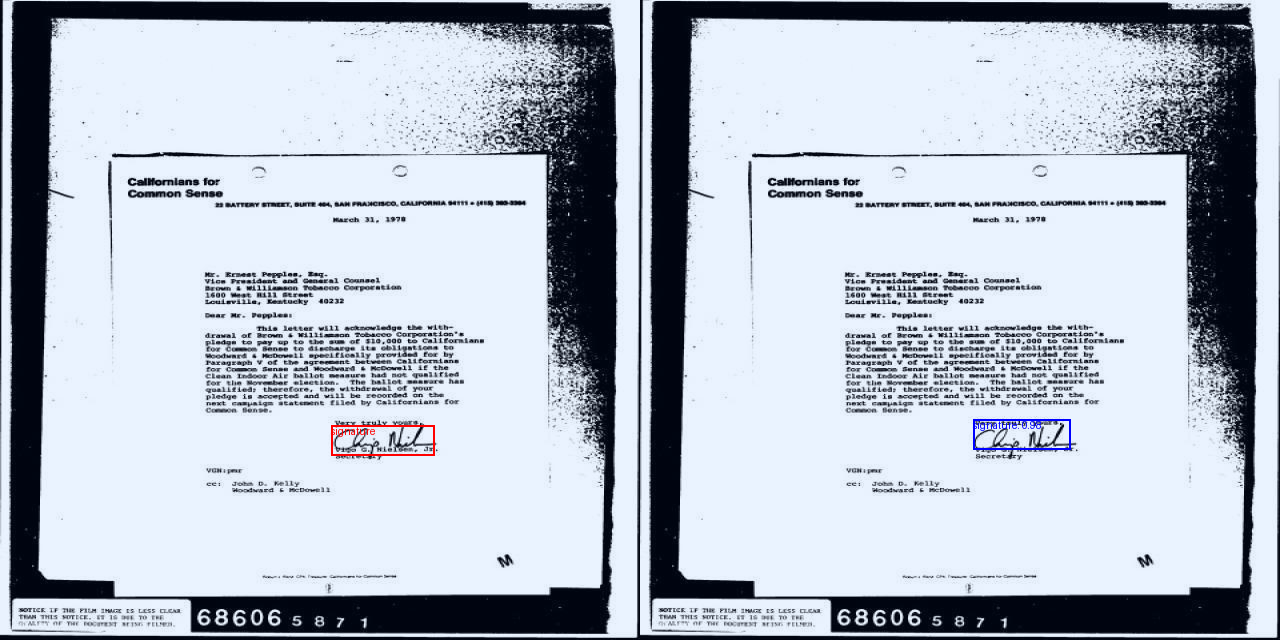

In [35]:
from utils.visualizer import visualize_prediction

item_idx = 6
visualize_prediction(test_dataset[item_idx], predictions[item_idx])